# 카메라 스티커앱 만들기 첫걸음

카메라앱 만들기를 통해 동영상 처리, 검출, 키포인트 추정, 추적, 카메라 원근의 기술을 다룹니다.

간단한 스티커부터 시작해서 각도 변화가 가능하고 거리 변화에 강건한 스티커까지 만들 수 있습니다.


# 학습 목표
1. 얼굴인식 카메라의 흐름 이해
2. dlib 라이브러리 사용
3. 이미지 배열의 인덱싱 예외 처리
4. 준비물


# 어떻게 만들까? 사진 준비하기!
- 눈, 코, 입, 귀와 같은 얼굴 각각의 위치를 아는 것이 중요하다!
-> landmark, alignment로 이 위치들을 찾아 낼 수 있다.
= Keypoint detection.

face landmark dataset = {눈, 코, 입, 턱}

In [1]:
# 이미지 처리를 위한 opencv
# 이미지 출력을 위한 matplotlib

import os
import cv2
import matplotlib.pyplot as plt 
import numpy as np
import dlib
print("💞")

💞


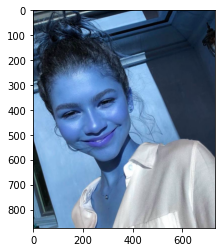

In [8]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/zendaya.jpg'
img_bgr = cv2.imread(my_image_path)    
img_show = img_bgr.copy()    
plt.imshow(img_bgr)
plt.show()

# 이미지를 읽었는데 얼굴이 푸른 빛이다. 왜?
# matplotlib, dlib 등의 이미지 라이브러리는 모두 이미지 채널을 RGB로 하는 반면, opencv는 BGR을 사용하기 때문이다. 
# 색깔 보정처리가 필요하다. 

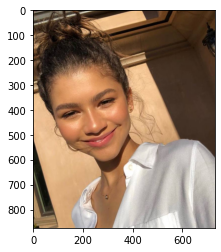

In [9]:
#색깔 보정처리

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# 얼굴 검출 face detection

dlib의 face detector는 HOG(Histogram of Oriented Gradients)와 SVM(Support Vector Machine)을 사용해서 얼굴을 찾습니다.

HOG는 이미지에서 색상의 변화량을 나타낸 것입니다. 딥러닝이 나오기 이전에 다양하게 사용되던 방식인데요.


sliding window는 작은 영역(window)을 이동해가며 확인하는 방법을 말합니다. 
큰 이미지의 작은 영역을 잘라 얼굴이 있는지 확인하고, 
다시 작은 영역을 옆으로 옮겨 얼굴이 있는지 확인하는 방식이겠네요. 
물론 이렇게 한다면 이미지가 크면 클수록 오래걸리는 단점이 있습니다. 
바로 이 지점이 딥러닝이 필요해지는 이유이기도 하지요.

In [11]:
# detector를 선언합니다

detector_hog = dlib.get_frontal_face_detector()
print("🌫🛸")


🌫🛸


In [12]:
# detector_hog를 이용해서 얼굴의 bounding box를 추출합니다.

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print("🌫🛸")




🌫🛸


dlib은 rgb 이미지를 입력으로 받기 때문에 cvtColor()를 이용해서 opencv 의 bgr 이미지를 rgb로 변환해 주었습니다.

detector_hog의 두 번째 파라미터는 이미지 피라미드의 수입니다.
이미지를 upsampling 방법을 통해 크기를 키우는 것을 이미지 피라미드라고 합니다.
이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능합니다. 이미지 피라미드에 대한 내용은 아래 링크를 참고해 주세요.


➰ upsampling이란,
간단하게 데이터의 크기를 키우는 것입니다. 일반적으로 CNN의 레이어를 통과하면서 이미지의 크기를 줄이는 것을 down sampling이라고 하는데, down sampling의 반대 개념이 upsampling인 셈이죠.

rectangles[[(98, 277) (419, 598)]]


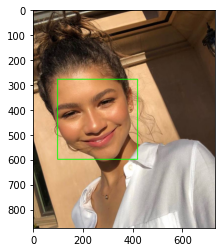

In [13]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 3-4 얼굴 랜드마크
이목구비의 위치를 추론하는 것을 face landmark localization 기술이라고 합니다. face landmark는 detection 의 결과물인 bounding box 로 잘라낸(crop) 얼굴 이미지를 이용합니다.

Object keypoint estimation 알고리즘

Face landmark와 같이 객체 내부의 점을 찾는 기술을 object keypoint estimation이라고 합니다. keypoint를 찾는 알고리즘은 크게 2가지로 나누어 집니다.

1) top-down : bounding box를 찾고 box 내부의 keypoint를 예측

2) bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

In [15]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [16]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


points 는 dlib.full_object_detection 의 객체이기 때문에 parts() 함수로 개별 위치에 접근할 수 있습니다. 
조금 더 직관적인 (x, y) 형태로 접근할 수 있도록 변환해 주었습니다. 
따라서 list_points 는 tuple (x, y) 68개로 이루어진 리스트가 됩니다. 
이미지에서 찾아진 얼굴 개수마다 반복하면 list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장됩니다.

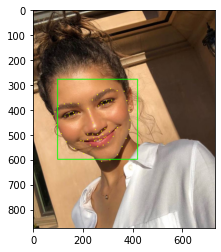

In [17]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 3-5 스티커 적용하기

In [18]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(250, 479)
(x,y) : (250,318)
(w,h) : (322,322)


In [19]:
# 스티커 이미지 읽어서 적용하기 

sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(322, 322, 3)


In [20]:
# 왕관 사이즈 resize. x,y좌표 수정

refined_x = x - w // 2
refined_y = y - h
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (89,-4)


### y 값이 -4 (음수)가 나온 이유는?스티커의 시작점이 얼굴 사진 영역을 벗어났기 때문이다. 
음수에 대한 예외처리가 필요함. 
원본 이미지의 범위를 벗어난 스티커 부분은 제거해줘야한다. 

In [21]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (89,0)


In [22]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
print("슝~")

슝~


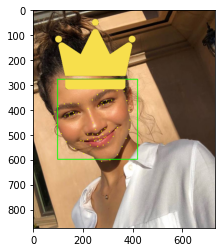

In [23]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

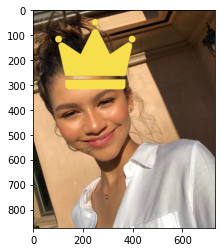

In [24]:
# bounding box와 landmark를 제거하고 최종결과만 출력하기

sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

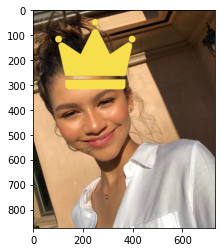

In [25]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 왕관 스티커가 제대로 맞지 않는 이유는?  사용된 사진 속 얼굴이 기울어져 있기 때문이다. 